# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
# Импорт библиотек
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Открытие файла данных
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
except:
    data = pd.read_csv('real_estate_data.csv', sep='\t')
# Проверка полноты и типа данных
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
# data.info()
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

<div class="alert alert-info"> <b>Комментарии студента:</b> Будем знать теперь </div>

In [4]:
data.query('airports_nearest.isna()').count()

total_images            5542
last_price              5542
total_area              5542
first_day_exposition    5542
rooms                   5542
ceiling_height          2964
floors_total            5532
living_area             4917
floor                   5542
is_apartment             631
studio                  5542
open_plan               5542
kitchen_area            4825
balcony                 2825
locality_name           5534
airports_nearest           0
cityCenters_nearest       24
parks_around3000          24
parks_nearest             20
ponds_around3000          24
ponds_nearest              8
days_exposition         4675
dtype: int64

Довольно-таки много пропусков

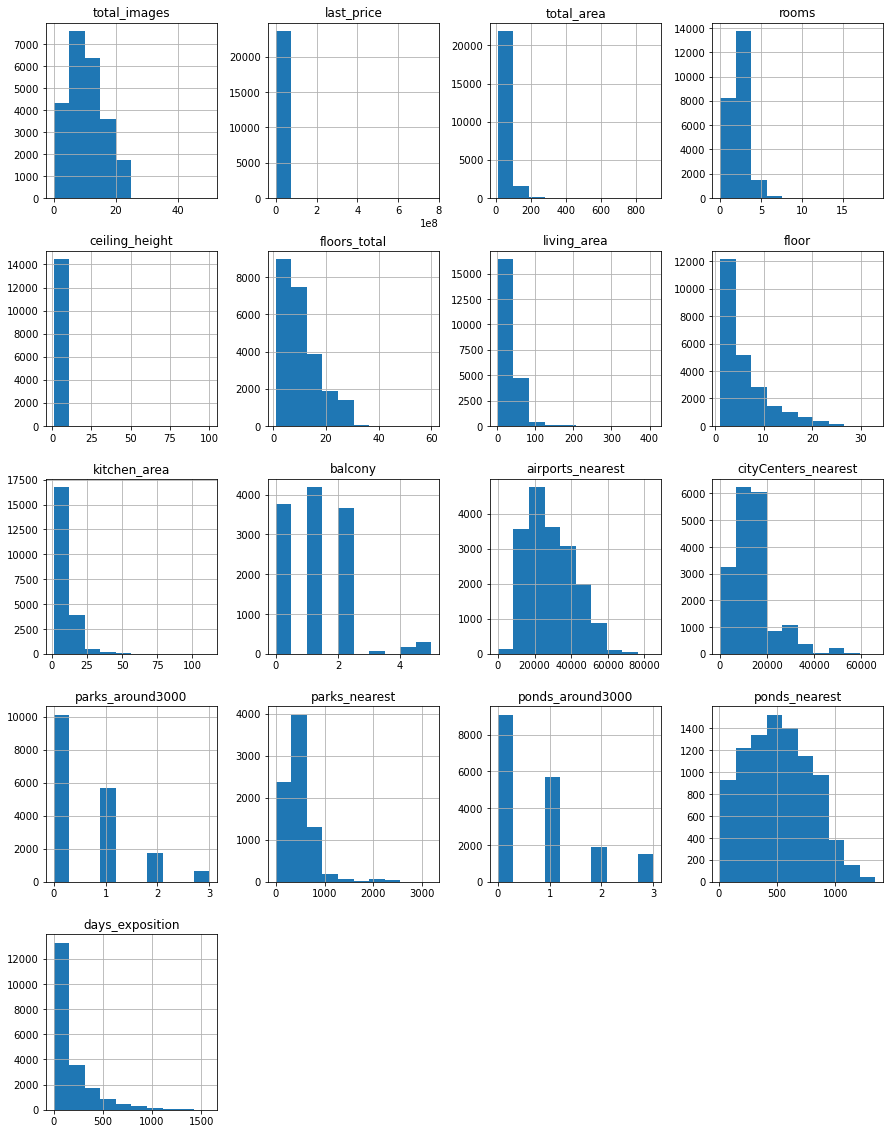

In [5]:
# Визуализация исходных данных
hist = data.hist(figsize=(15, 20))

В целом данные соответствуют известным распределениям

## Предобработка данных

### Заполнение пропусков и замена типов данных

In [6]:
# Тип недвижимости - "не апартаменты", если не указано иное
data['is_apartment'] = data['is_apartment'].fillna(value=False)

In [7]:
# Количество балконов = 0, если не указано
data['balcony'] = data['balcony'].fillna(0).astype(int)

In [8]:
# Количество парков поблизости = 0, если не указано
data['parks_around3000'] = data['parks_around3000'].fillna(0).astype(int)
# Количество водоемов поблизости = 0, если не указано
data['ponds_around3000'] = data['ponds_around3000'].fillna(0).astype(int)

Неясно как может влиять расстояние до ближайшего парка / водоема (далее 3 км от объекта) на задачи исследования,
Возможно будет важнее учесть только наличие / количество оных в пешей доступности (до 3 км)

In [9]:
# Удаление столбцов с расстоянием до парка / водоема при их отсутствии
# data = data.drop(columns=['parks_nearest', 'ponds_nearest'], axis=1)

In [10]:
# Вообще количество пропущенных геоданных в ячейках расстояний очень близки, 
# что может свидетельствовать об ошибках выгрузки / заполнения

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               23699 non-null  int32  
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [11]:
# Фильтр по названиям населенных пунктов
print(data['locality_name'].nunique()) # Количество уникальных названий населенных пунктов
set(data['locality_name']) # Множество названий населенных пунктов

# data.pivot_table(index='locality_name', values=['total_area', 'rooms'], aggfunc=['count', 'median'])
# data.head()

364


{nan,
 'Бокситогорск',
 'Волосово',
 'Волхов',
 'Всеволожск',
 'Выборг',
 'Высоцк',
 'Гатчина',
 'Зеленогорск',
 'Ивангород',
 'Каменногорск',
 'Кингисепп',
 'Кириши',
 'Кировск',
 'Колпино',
 'Коммунар',
 'Красное Село',
 'Кронштадт',
 'Кудрово',
 'Лодейное Поле',
 'Ломоносов',
 'Луга',
 'Любань',
 'Мурино',
 'Никольское',
 'Новая Ладога',
 'Отрадное',
 'Павловск',
 'Петергоф',
 'Пикалёво',
 'Подпорожье',
 'Приморск',
 'Приозерск',
 'Пушкин',
 'Санкт-Петербург',
 'Светогорск',
 'Сертолово',
 'Сестрорецк',
 'Сланцы',
 'Сосновый Бор',
 'Сясьстрой',
 'Тихвин',
 'Тосно',
 'Шлиссельбург',
 'городской поселок Большая Ижора',
 'городской поселок Янино-1',
 'городской посёлок Будогощь',
 'городской посёлок Виллози',
 'городской посёлок Лесогорский',
 'городской посёлок Мга',
 'городской посёлок Назия',
 'городской посёлок Новоселье',
 'городской посёлок Павлово',
 'городской посёлок Рощино',
 'городской посёлок Свирьстрой',
 'городской посёлок Советский',
 'городской посёлок Фёдоровское',
 'г

In [12]:
# Удаление пропущенных названий населенных пунктов
data['locality_name'] = data['locality_name'].dropna(axis=0).reset_index(drop=True)
len(set(data['locality_name']))
# data.info()

365

In [13]:
# Унификация название населенных пунктов
n = (
    ['поселок', 'городской', 'коттеджный', 'посёлок', 'городского типа', 
     'деревня', 'железнодорожной', 'садовое', 'садоводческое', 'при']
) # Список "лишних" слов в названиях

for i in n: 
    print(i)
    data['locality_name'] = data['locality_name'].apply(lambda x: str(x).replace(i,'').strip()) # Удаление лишних слов и пробелов
# print(len(set(data['locality_name']))) # Количество уникальных названий
data # Отфильтрованные данные

поселок
городской
коттеджный
посёлок
городского типа
деревня
железнодорожной
садовое
садоводческое
при


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,False,...,25.00,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,False,...,11.00,2,Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,False,...,8.30,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,False,...,NaN,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,False,...,41.00,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.70,5.0,73.3,3,False,...,13.83,0,nan,24665.0,4232.0,1,796.0,3,381.0,NaN
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.0,4,False,...,8.50,0,nan,NaN,NaN,0,NaN,0,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.7,1,False,...,NaN,0,nan,NaN,NaN,0,NaN,0,NaN,NaN
23697,13,11475000.0,76.75,2017-03-28T00:00:00,2,3.00,17.0,NaN,12,False,...,23.30,2,nan,39140.0,10364.0,2,173.0,3,196.0,602.0


In [14]:
# Классификация квартир по общей площади
# print(len(data['total_area'].unique()))
data['area_category'] = (
    pd.cut(data['total_area'], [0,15,35,65,80,100,200,400,np.inf],
           labels=['box', 'tiny', 'small','medium','normal','big','large','huge'])
)
# print(len(data['area_category'].unique()))
# Заполнение пропущенных значений
data['living_area'] = data['living_area'].fillna(data.groupby('area_category')['living_area'].transform('median'))
data['kitchen_area'] = data['kitchen_area'].fillna(data.groupby('area_category')['kitchen_area'].transform('median'))

data['other_area'] = (
    data['total_area']-data['kitchen_area']-data['living_area']
    #[data['total_area']-data['kitchen_area']-data['living_area']]
) # Часть общей площади за вычетом жилой и кухни - может пригодиться, если сумма кухни и комнат больше общей

data.pivot_table(index=['area_category'], values=['total_area', 'kitchen_area', 'living_area', 'other_area'], aggfunc=('median', 'count'))

kitchen_area        living_area         other_area          \
                     count median       count  median      count  median   
area_category                                                              
box                      8    2.0           8   10.00          8    1.00   
tiny                  3514    7.0        3514   17.00       3514    7.80   
small                13232    8.7       13232   28.30      13232   11.80   
medium                3200   10.4        3200   43.10       3200   18.00   
normal                1909   13.0        1909   52.00       1909   23.00   
big                   1609   16.0        1609   72.20       1609   32.00   
large                  204   25.8         204  154.35        204   69.15   
huge                    23   40.0          23  279.60         23  173.00   

              total_area         
                   count median  
area_category                    
box                    8   13.1  
tiny                3514   31.9  
small              13232   47.0  
medium              3200   72.0  
normal              1909   88.9  
big                 1609  121.2  
large                204  244.5  
huge                  23  491.0

In [15]:
# Проверка ошибочно заполненных значений
data.query('kitchen_area + living_area > total_area')['other_area']#.count()

184     -2.10
424     -3.00
440     -4.64
545     -1.20
551     -8.24
         ... 
23202   -8.12
23238   -0.20
23292   -1.54
23457   -1.00
23579   -0.20
Name: other_area, Length: 275, dtype: float64

Довольно много значений, однако их можно постараться учесть в дальнейшем исследовании

In [16]:
# Классификация зданий по высоте
data['building_category'] = (
    pd.cut(data['floors_total'], [0,5,10,17,30,np.inf],
           labels=['low', 'med', 'modern','high','skyscraper'])
)
# Заполнение пропущенной этажности
data['floors_total'] = data['floors_total'].fillna(data.groupby('building_category')['floors_total'].transform('median'))

# Удаление выпадающих значений
data['building_category'] = data['building_category'].dropna()
data['floors_total'] = data['floors_total']#.astype(int)
# data['floors_total'].head(50)
# data.pivot_table(index=['building_category', 'area_category'], values=['floor', 'floors_total'], aggfunc=('median', 'count'), dropna=False)

# Проверка на попадание этажа в общую этажность здания
# data.loc[data['floor'] > data['floors_total']].head(30)
# Проверка на отсутствие пропусков
#data['floors_total'].isna().sum()

In [17]:
# Обработка объектов по высоте потолков
(data.loc[(data['ceiling_height'] < 2.5) | (data['ceiling_height'] >= 4.6)]
.sort_values(by='ceiling_height', ascending=False)#.head(30)
)

(data.pivot_table(
    index=['area_category', 'building_category'], 
    values='ceiling_height', 
    aggfunc=('count', 'median'), dropna=False).
unstack()
)

count                              median               \
building_category   low   med modern high skyscraper    low   med modern   
area_category                                                              
box                   3     2      0    0          0   2.55  2.65    NaN   
tiny                782   647    346  269          3   2.50  2.53  2.600   
small              2805  2421   1690  988          6   2.55  2.56  2.650   
medium              642   677    475  252          5   2.95  2.60  2.700   
normal              380   360    298  195          0   3.00  2.80  2.700   
big                 393   379    196  136          0   3.15  3.05  2.800   
large                72    48      8    1          0   3.31  3.50  2.805   
huge                  2    10      2    2          0   3.50  3.45  2.775   

                                     
building_category   high skyscraper  
area_category                        
box                  NaN        NaN  
tiny               2.700      2.680  
small              2.710      2.675  
medium             2.750      2.700  
normal             2.750        NaN  
big                2.800        NaN  
large              2.800        NaN  
huge               2.875        NaN

In [18]:
# Заполнение пропусков по высоте потолков медианами по площиди квартир и типу здания
data['ceiling_height'] = data['ceiling_height'].fillna(data.groupby(['building_category', 'area_category'])['ceiling_height'].transform('median'))
data['ceiling_height'] = data['ceiling_height'].dropna(axis=0)

# Обработка высоких потолков
data.loc[data['ceiling_height'] > 20, 'ceiling_height'] = data.loc[data['ceiling_height'] > 20]['ceiling_height'].div(10)
data.loc[data['ceiling_height'] > 10, 'ceiling_height'] = data.loc[data['ceiling_height'] > 10]['ceiling_height'].div(5)
data.loc[data['ceiling_height'] >= 4.6, 'ceiling_height'] = data.loc[data['ceiling_height'] >= 4.6]['ceiling_height'].div(2)
# Обработка низких потолков
data.loc[data['ceiling_height'] < 2.4, 'ceiling_height'] = data.loc[data['ceiling_height'] < 2.4]['ceiling_height'].apply(lambda x: x/x*2.4)
#data.info()

# Проверка высоты потолков
# data.sort_values('ceiling_height', ascending=False).head(60)
# data.pivot_table(index=['area_category', 'building_category'], values='ceiling_height', aggfunc=('count', 'median'), dropna=False).unstack()
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height             80
floors_total               86
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000            0
parks_nearest           15620
ponds_around3000            0
ponds_nearest           14589
days_exposition          3181
area_category               0
other_area                  0
building_category          86
dtype: int64

In [19]:
# Попытка группировки расстояний до центра и аэропорта по населенным пунктам
(data.pivot_table(index='locality_name', 
                  values=('cityCenters_nearest', 'airports_nearest', 'total_area'), 
                  aggfunc=('count', 'median'))
)

airports_nearest          cityCenters_nearest  \
                                     count   median               count   
locality_name                                                             
nan                                     36  26574.0                  36   
Агалатово                                4  24188.0                   4   
Александровская                          2  19491.5                   2   
Алексеевка                               1  26711.0                   1   
Аннино                                  11  30784.0                  11   
...                                    ...      ...                 ...   
станции Свирь                            2  37459.5                   2   
товарищество Новая Ропша                 0      NaN                   0   
товарищество Приладожский                0      NaN                   0   
товарищество Рахья                       0      NaN                   0   
товарищество Садко                       1  27102.0                   1   

                                   total_area         
                            median      count median  
locality_name                                         
nan                        13123.0         49   47.0  
Агалатово                  11812.0          4   48.4  
Александровская            16201.5          2  146.0  
Алексеевка                  5559.0          1  312.0  
Аннино                     12886.0         16   57.1  
...                            ...        ...    ...  
станции Свирь              13294.0          2   47.7  
товарищество Новая Ропша       NaN          1   37.0  
товарищество Приладожский      NaN          1   52.0  
товарищество Рахья             NaN          1   51.0  
товарищество Садко          7442.0          1  131.1  

[311 rows x 6 columns]

In [20]:
# Заполнение расстояний от центра и аэропорта медианами по населенным пунктам (где возможно)
data['cityCenters_nearest'] = (data['cityCenters_nearest']
                               .fillna(data.groupby('locality_name')['cityCenters_nearest']
                                       .transform('median'))
                              )
data['airports_nearest'] = (data['airports_nearest'].
                            fillna(data.groupby('locality_name')['airports_nearest'].
                                   transform('median'))
                           )
(data.pivot_table(index='locality_name', 
             values=('cityCenters_nearest', 'airports_nearest'), 
             aggfunc=('median', 'count')).sample(30)
)
#data.isna().sum()
(data.query('locality_name == "Санкт-Петербург"')['cityCenters_nearest'] == 0).sum()

0

In [21]:
# Перевод строки даты в "календарный" формат с округлением до дня
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT').dt.round('1D')
data.first_day_exposition

0       2019-03-07
1       2018-12-04
2       2015-08-20
3       2015-07-24
4       2018-06-19
           ...    
23694   2017-03-21
23695   2018-01-15
23696   2018-02-11
23697   2017-03-28
23698   2017-07-21
Name: first_day_exposition, Length: 23699, dtype: datetime64[ns]

22478


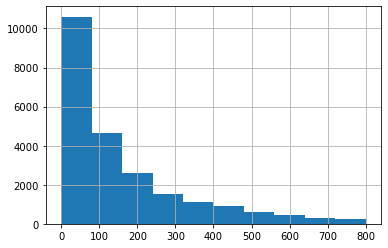

In [22]:
# Определение даты выгрузки базы как следующий день за датой публикации самых поздних объявлений
dwnld_date = data.first_day_exposition.max() + pd.Timedelta(days=1).round('1D')

# print(dwnld_date)
# data.first_day_exposition.dtype
# data['days_exposition'].dtype
# x = int((dwnld_date - pd.to_datetime('2018-03-03')) / pd.Timedelta(days=1))

# Заполнение пропущенного количества дней видимости объявления,
# предполагая, что объявление не было снято до момента выгрузки базы

data['days_exposition'] = data['days_exposition'].fillna((dwnld_date - data.first_day_exposition).dt.days) # / pd.Timedelta(days=1)) 
data['days_exposition'] = data['days_exposition'].astype(int) # Перевод формата в целочисленный

print(data['days_exposition'].duplicated().sum())
data['days_exposition'].sort_values().hist(bins=10, range=(0, 800))
plt.show()
# data.isna().sum()
# data.info()
#data

Количество дней активности объявления (до продажи объекта / снятия с продажи) было проанализировано, и пропущенные значения заполнены, исходя из гипотезы, что объявление оставалось активным вплоть до момента выгрузки базы

In [23]:
data.duplicated().sum()

0

#### Вывод по предобработке

+ Исходные данные содержали ок. 24 тыс. записей
+ Большая часть записей (5.5 тыс.) не имели заполненных данных геолокации
+ Многие записи содержали ошибки или пропущенные значения

### Посчитайте и добавьте в таблицу новые столбцы

In [24]:
# Определение цены за кв.метр общей площади
data['sqm_price'] = (data.last_price / data.total_area).round(2)
data.sqm_price
# Календарные параметры публикации объявления
data['publish_weekday'] = data.first_day_exposition.dt.weekday # День недели публикации
data['publish_month'] = data.first_day_exposition.dt.month # Месяц публикации
data['publish_year'] = data.first_day_exposition.dt.year # Год публикации
(data.pivot_table(
    index=['publish_year', 'publish_month', 'publish_weekday'], values=['area_category', 'sqm_price'],
    aggfunc=['count', 'median'])
) # Просмотр значений


count                median
                                           area_category sqm_price   sqm_price
publish_year publish_month publish_weekday                                    
2014         11            3                          19        19  137167.540
                           5                           1         1  102996.250
             12            0                          17        17   94736.840
                           1                          35        35  150000.000
                           2                          27        27   90909.090
...                                                  ...       ...         ...
2019         4             5                          65        65   95812.810
                           6                          55        55  104750.000
             5             2                          30        30  123168.370
                           3                          11        11   97701.150
                           4                          20        20  100578.035

[376 rows x 3 columns]

In [25]:
# Категория этажа

data['floor_type'] = data['floors_total'] - data['floor'] # Сравнение этажа с этажностью
data['floor_type'] = (data.apply(lambda x: 'Последний' if x['floor_type']==0 
                                 else ('Первый' if x['floor']==1 else 'Другой'),axis=1)
                     )

(data.pivot_table(index=[ 'building_category', 'area_category'], 
                  values=['sqm_price'], columns='floor_type', aggfunc=('count', 'median')) # Проверка
)
# Количество различных объектов по общей площади и категории здания и средняя цена за кв.м 

sqm_price                               \
                                    count                       median   
floor_type                         Другой Первый Последний      Другой   
building_category area_category                                          
low               box                   3      3         0  200000.000   
                  tiny                670    297       304   87059.675   
                  small              2392   1058      1156   78293.525   
                  medium              500    211       259   89944.690   
                  normal              318     87       148   98954.095   
                  big                 323     69       146  105513.960   
                  large                66     11        38  119668.790   
                  huge                  1      1         3   96711.800   
med               box                   0      2         0         NaN   
                  tiny                736    116       109  103898.760   
                  small              2819    438       413   92465.750   
                  medium              756    152       106   90071.925   
                  normal              417     61        61  105294.830   
                  big                 453     28        80  128703.700   
                  large                53      1        17  177272.730   
                  huge                  5      0         8  126865.670   
modern            box                   0      0         0         NaN   
                  tiny                525     37        43  104687.500   
                  small              2490    146       178  103571.430   
                  medium              636     42        59  101504.960   
                  normal              402     19        36  108370.240   
                  big                 258     13        21  130406.070   
                  large                 8      0         6   88427.585   
                  huge                  2      0         0   75676.365   
high              box                   0      0         0         NaN   
                  tiny                611     17        27  105294.120   
                  small              1946     55        90  104568.645   
                  medium              430     12        15  104414.180   
                  normal              328      8        15  104163.905   
                  big                 179      5        21  123853.210   
                  large                 2      0         1   58889.195   
                  huge                  2      0         1  155847.970   
skyscraper        box                   0      0         0         NaN   
                  tiny                  3      0         0  139112.900   
                  small                15      0         0  107538.460   
                  medium               11      0         0  107299.270   
                  normal                0      0         0         NaN   
                  big                   3      0         0   98019.800   
                  large                 0      0         0         NaN   
                  huge                  0      0         0         NaN   

                                                         
                                                         
floor_type                           Первый   Последний  
building_category area_category                          
low               box            126666.670         NaN  
                  tiny            80893.630   81261.040  
                  small           71261.505   69455.880  
                  medium          70833.330   89337.180  
                  normal          91799.270   96125.835  
                  big            101798.860   95822.370  
                  large          117905.680  113684.805  
                  huge            43402.780  221799.750  
med               box            105512.820         NaN  
                  tin

In [26]:
# Перевод расстояния до центра города в км (с округлением до целых)
# (data.query('locality_name == "Санкт-Петербург"')['cityCenters_nearest'] < 500).sum()
data['city_center_km'] = np.ceil(data['cityCenters_nearest'] / 1000) # Перевод в км
# Заполнение пропусков по населенным пунктам, где возможно
data['city_center_km'].fillna(data.groupby(data['locality_name'])['city_center_km'].transform('median'))
# data['city_center_km'] = data['city_center_km'].astype('Int64') # Перевод в целочисленный тип данных
(data.query('locality_name == "Санкт-Петербург"')['city_center_km'].isna().sum()) # Проверка
#(data.query('locality_name == "Санкт-Петербург"')['city_center_km'] == 0).sum()

0

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23619 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

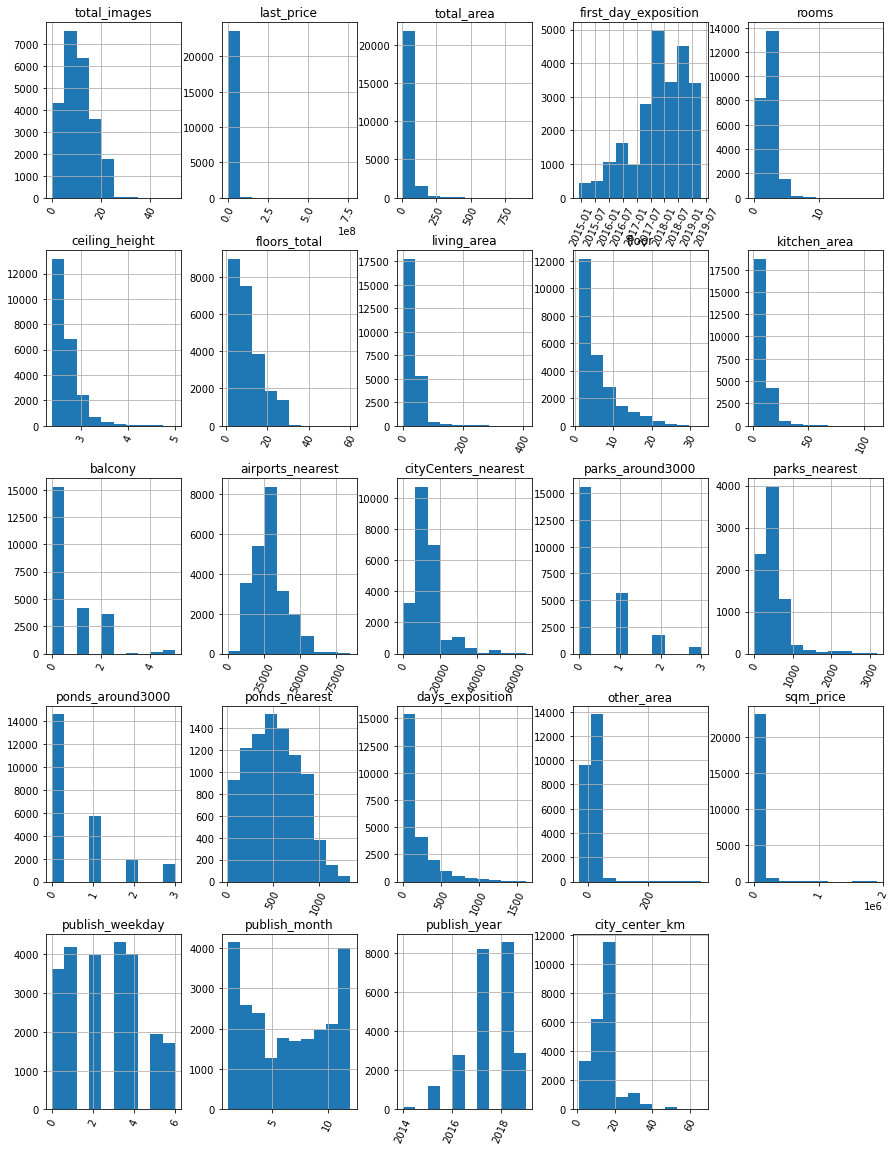

In [28]:
# Проверка обновленных данных
hist = data.hist(figsize=(15, 20), xrot=65, bins=10)

## Промежуточные выводы после предварительной обработки данных

- Большинство объектов с количеством фотографий от 10 до 20, почти все объекты имеют до 30 фото
- Как видно из графика, в летние месяцы активность размещения объявлений заметно падает
- От года к году предложений на рынке становится больше
- В выходные дни активность публикации объявлений составляет около половины от числа публикаций в будние дни
- Стандартная высота потолока менее 4 метров, остальные данные могут быть ошибками ввода, но их количество не должно значительно повлиять на результат исследования
- Наибольшее количество объектов расположено не выше 20 этажа (причем основная доля до 10-го)
- Более половины всех объектов не имеет балкона
- Расстояние до аэропорта у большинства объектов от 8 до 50 км
- Большнство объектов находится не далее 20 км от центра города
- Более половины всех объектов не имеют парков и водоемов в шаговой доступности
- Ок. 80% всех объявлений закрываются в течение года

### Проведите исследовательский анализ данных

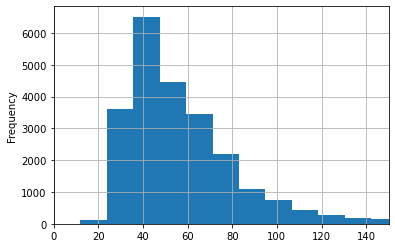

In [29]:
# Построение гистограмм для отдельных параметров
# Общая площадь
data['total_area'].plot(kind='hist', bins=75, grid='on', xlim=(0,150))
plt.show()

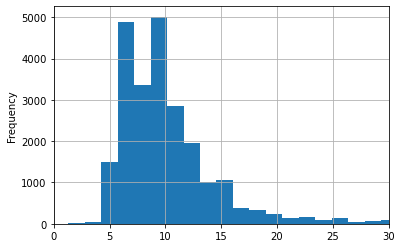

In [30]:
# Площадь кухни
data['kitchen_area'].plot(kind='hist', bins=75, grid='on', xlim=(0,30))
plt.show()

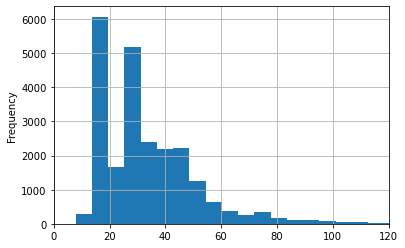

In [31]:
# Жилая площадь
data['living_area'].plot(kind='hist', bins=70, grid='on', xlim=(0,120))
plt.show()

Странный провал в количестве объектов с жилой площадью от 20 до 30 кв.м

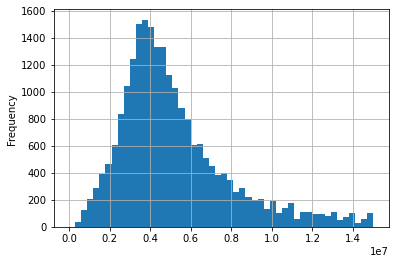

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,area_category,other_area,building_category,sqm_price,publish_weekday,publish_month,publish_year,floor_type,city_center_km
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.0,8,False,...,58,big,32.00,modern,120370.37,3,3,2019,Другой,17.0
3,0,64900000.0,159.00,2015-07-24,3,2.80,14.0,72.2,9,False,...,424,big,70.80,modern,408176.10,4,7,2015,Другой,7.0
19,16,14200000.0,121.00,2019-01-09,3,2.75,16.0,76.0,8,False,...,97,big,33.00,modern,117355.37,2,1,2019,Другой,13.0
35,6,15500000.0,149.00,2017-06-26,5,3.15,5.0,104.0,4,False,...,644,big,28.00,low,104026.85,0,6,2017,Другой,4.0
42,13,22000000.0,161.80,2015-07-08,4,2.80,4.0,80.9,2,False,...,987,big,63.30,low,135970.33,2,7,2015,Другой,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23631,17,14799000.0,104.00,2018-11-18,3,3.10,4.0,66.0,2,False,...,90,big,24.00,low,142298.08,6,11,2018,Другой,14.0
23648,14,10100000.0,78.00,2017-05-12,3,3.27,5.0,48.6,5,False,...,621,medium,21.20,low,129487.18,4,5,2017,Последний,2.0
23653,10,11000000.0,74.00,2018-11-04,2,2.50,18.0,40.0,10,False,...,181,medium,23.50,high,148648.65,6,11,2018,Другой,13.0
23684,20,21400000.0,145.00,2018-11-02,4,3.00,26.0,71.4,17,False,...,183,big,58.00,high,147586.21,4,11,2018,Другой,12.0


In [32]:
# Цена объекта
data['last_price'].plot(kind='hist', bins=50, grid='on', range=(0,1.5e7))
plt.show()
data.query('last_price > 1e7')

Цена большинства объектов не превышает 20 млн. руб., 80% цен находится в диапазоне от 2.0 до 10.0 млн.

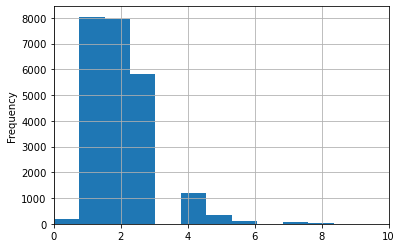

In [33]:
# Количество комнат
data['rooms'].plot(kind='hist', bins=25, grid='on', xlim=(0,10))
plt.show()

In [34]:
data.query('rooms < 1').last_price.agg(['count', 'median', 'sum'])

count           197.0
median      2700000.0
sum       657531650.0
Name: last_price, dtype: float64

Обнаружилось некоторое количество объектов (194) с нулевым количеством комнат
Возможно ошибки внесения данных

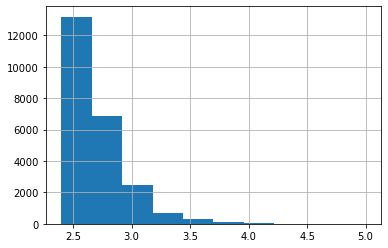

In [35]:
# Высота потолков
data['ceiling_height'].hist(bins=10, grid='on')
plt.show()

Основное количество объектов имеет вполне адекватные данные о высоте потолков (до 3.5 м)

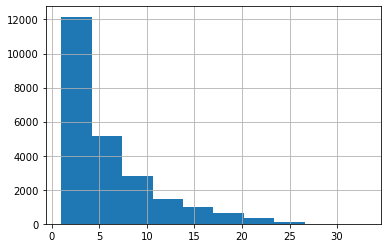

In [36]:
# Этаж расположения объекта
data['floor'].hist(bins=10, grid='on')
plt.show()

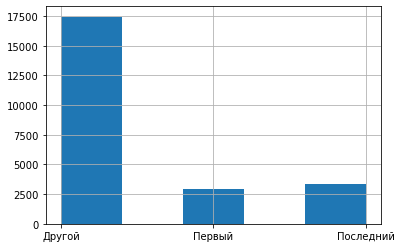

In [37]:
# Признак этажа
data['floor_type'].hist(bins=5, grid='on')
plt.show()

Большинство объектов (ок. 75%) располагаются на средних этажах зданий

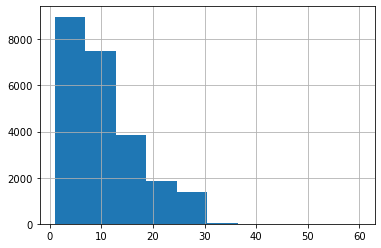

In [38]:
# Количество этажей в здании
data['floors_total'].hist(grid='on')
plt.show()

Почти все здания до 30 этажей, 80% из них до 20 этажей

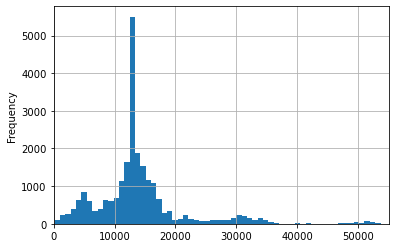

In [39]:
# Расстояние до центра города в метрах
data['cityCenters_nearest'].plot(kind='hist', bins=75, grid='on', xlim=(0, 55000))
plt.show()

Две трети объектов находятся в радиусе от 10 до 20 км от центра города, заметны всплески на расстоянии 30 и 50 км, возможно жилые комплексы, провал в значениях от 5 до 10 км

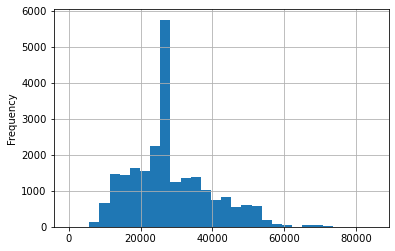

In [40]:
# Расстояние до аэропорта
data['airports_nearest'].plot(kind='hist', bins=30, grid='on')
plt.show()

Расстояние объектов до аэропорта от 10 до 50 км

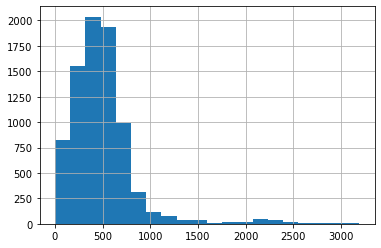

In [41]:
# Расстояние до ближайшего парка
data['parks_nearest'].hist(bins=20, grid='on')
plt.show()

Ближайшие парки располагаются не далее 1 км для большинства объектов, имеющих оные в шаговой доступности

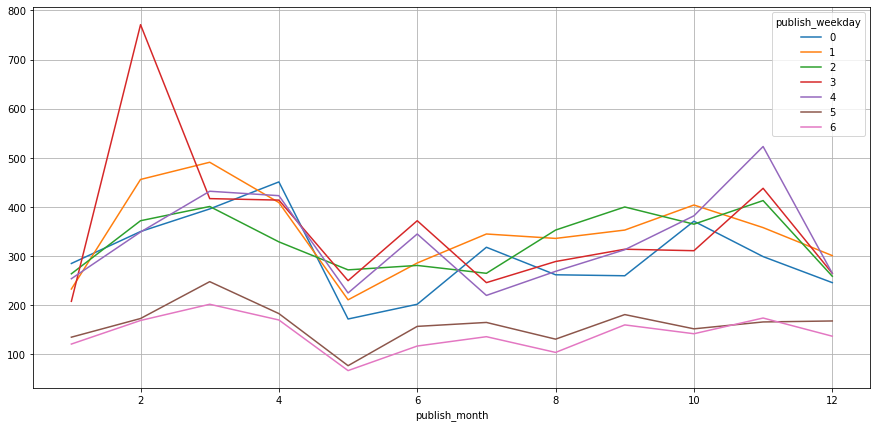

In [42]:
# День и месяц публикации объявления
# data['publish_month'].hist(bins=12)
# data['publish_weekday'].hist(bins=7)
(data.pivot_table(index=('publish_month'), columns=('publish_weekday'),
                  values='total_area', aggfunc=('count')).
 plot(kind='line', grid=True, figsize=(15, 7))
)
plt.show()

Набольшее количество объявлений публикуется по вторникам и четвергам, в летние месяцы заметен спад активности

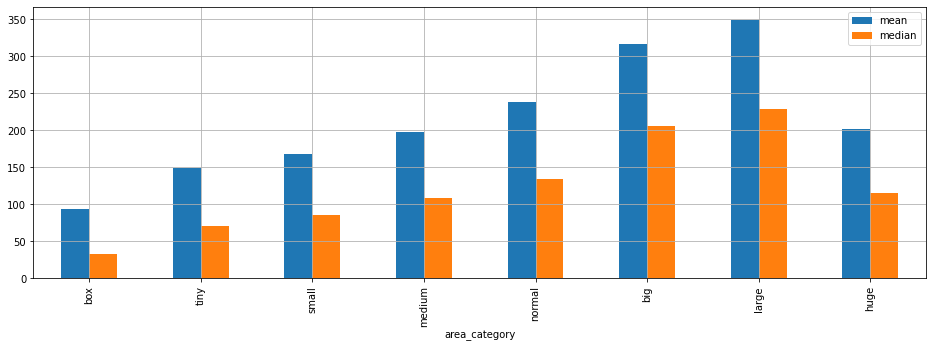

In [43]:
# Анализ скорости продажи объектов
(data.pivot_table(index=('area_category'),  values='days_exposition', aggfunc=('mean', 'median'))
.plot(kind='bar', grid=True, figsize=(16,5))
)
plt.show()

* Среднее значение сильно выбивается в большую сторону по сравнению с медианным по всем категориям объектов, что означает наличие объектов со слишком долгими сроками продажи
* Средним сроком продажи можно считать количество дней, попадающее в диапазон между медианой и средним арифметическим, все, что больше, можно считать необычно долгими
* Чем меньше квартира, тем быстрее продается, исключение составляют особенно просторные квартиры, это, видимо, зависит от количества предложений на рынке и категории покупателей

In [44]:
data.pivot_table(index=('area_category'),  values='days_exposition', aggfunc=('mean', 'median'))

,mean,median
area_category,,
box,94.125000,33.0
tiny,148.856005,70.0
small,167.290886,85.0
medium,196.815625,108.0
normal,238.497119,134.0
big,316.087632,205.0
large,349.151961,228.5
huge,201.347826,115.0


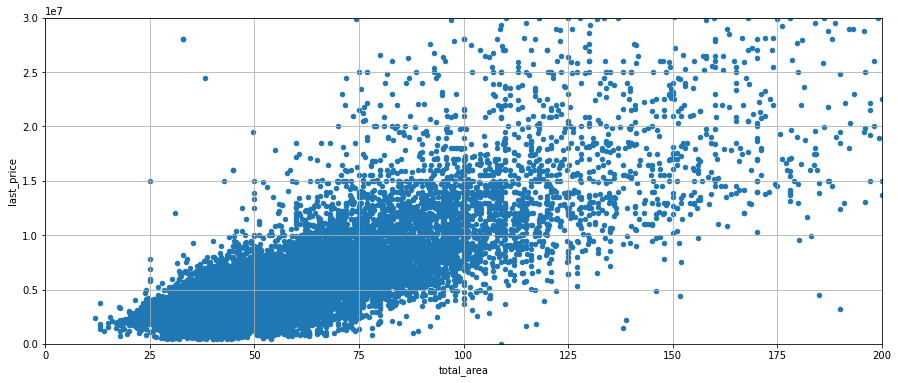

In [45]:
data['last_price'].groupby(data['building_category']).corr(data['total_area'])
data.plot(kind='scatter', x='total_area', y='last_price',
          grid=True, figsize=(15, 6), xlim=(0, 200), ylim=(0,3e7)
         )
plt.show()

Довольно высокая связь стоимости объекта с общей площадью по типам зданий

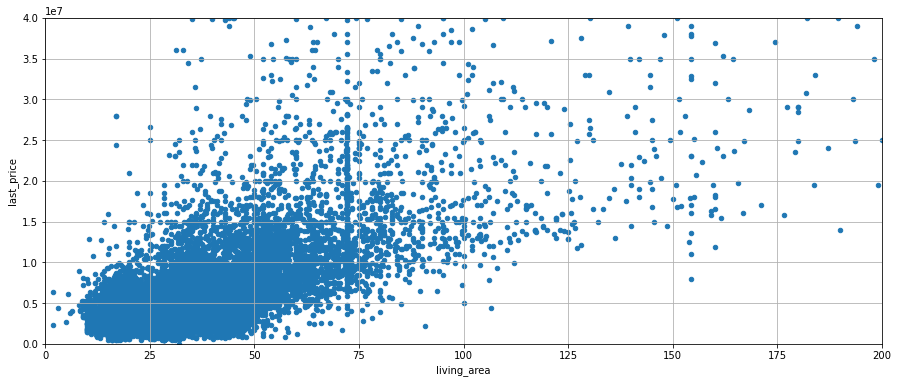

In [46]:
data['last_price'].groupby(data['building_category']).corr(data['living_area'])
data.plot(kind='scatter', x='living_area', y='last_price',
          grid=True, figsize=(15, 6), xlim=(0, 200), ylim=(0,4e7)
         )
plt.show()

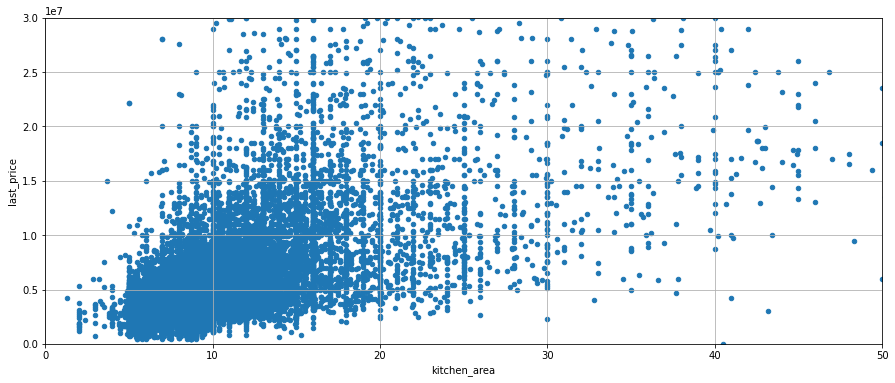

In [47]:
data['last_price'].groupby(data['building_category']).corr(data['kitchen_area'])
data.plot(kind='scatter', x='kitchen_area', y='last_price',
          grid=True, figsize=(15, 6), xlim=(0, 50), ylim=(0,3e7)
         )
plt.show()

Связь стоимости объекта с жилой площадью и площадью кухни заметно снижается

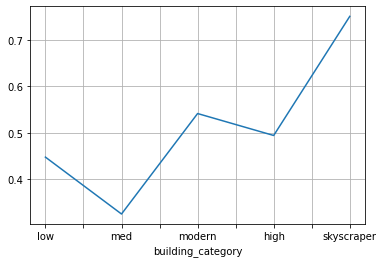

building_category
low           0.448056
med           0.325636
modern        0.541817
high          0.494610
skyscraper    0.750962
Name: last_price, dtype: float64

In [48]:
data['last_price'].groupby(data['building_category']).corr(data['rooms']).plot(grid=True)
plt.show()
data['last_price'].groupby(data['building_category']).corr(data['rooms'])

Количество комнат практически не влияет на общую стоимость. Корреляция около 0.5, т.е. довольно слабая

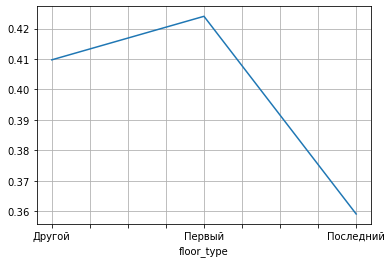

floor_type
Другой       0.701962
Первый       0.699910
Последний    0.633640
Name: last_price, dtype: float64

In [49]:
data['last_price'].groupby(data['floor_type']).corr(data['rooms']).plot(grid=True)
plt.show()
data['last_price'].groupby(data['floor_type']).corr(data['total_area'])

Цены объекта имеет среднюю связь с расположением на этажах 

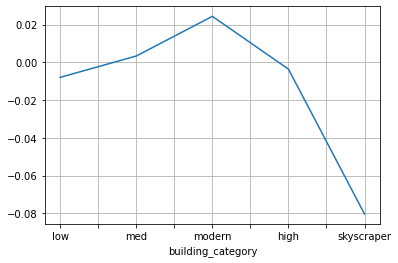

building_category
low          -0.007937
med           0.003366
modern        0.024384
high         -0.003567
skyscraper   -0.080298
Name: last_price, dtype: float64

In [50]:
data['last_price'].groupby(data['building_category']).corr(data['publish_weekday']).plot(grid=True)
plt.show()
data['last_price'].groupby(data['building_category']).corr(data['publish_weekday'])

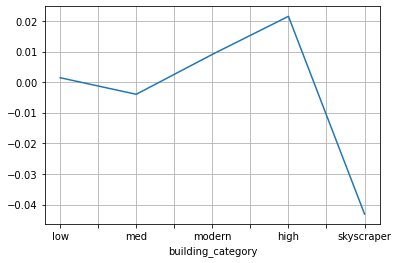

building_category
low           0.001444
med          -0.003971
modern        0.009074
high          0.021505
skyscraper   -0.043095
Name: last_price, dtype: float64

In [51]:
data['last_price'].groupby(data['building_category']).corr(data['publish_month']).plot(grid=True)
plt.show()
data['last_price'].groupby(data['building_category']).corr(data['publish_month'])

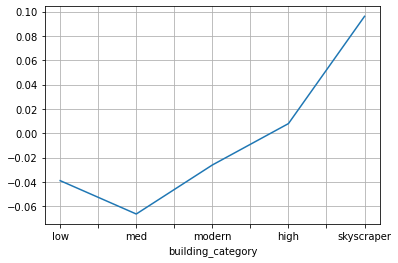

building_category
low          -0.038839
med          -0.066243
modern       -0.025976
high          0.008016
skyscraper    0.096119
Name: last_price, dtype: float64

In [52]:
data['last_price'].groupby(data['building_category']).corr(data['publish_year']).plot(grid=True)
plt.show()
data['last_price'].groupby(data['building_category']).corr(data['publish_year'])

Связь цены объекта с днем, месяцем и годом публикации практически не прослеживается

In [53]:
(data.pivot_table(index=('publish_year'), columns=['publish_weekday', 'publish_month'],
                  values=['last_price'], aggfunc='median').corr()
)


last_price                      \
publish_weekday                                   0                       
publish_month                                    1         2         3    
           publish_weekday publish_month                                  
last_price 0               1               1.000000  0.377268  0.921468   
                           2               0.377268  1.000000  0.401571   
                           3               0.921468  0.401571  1.000000   
                           4               0.986736  0.297015  0.886941   
                           5               0.788410 -0.272629  0.774204   
...                                             ...       ...       ...   
           6               8               0.926765  0.084622  0.713208   
                           9               0.972587  0.193653  0.956750   
                           10              0.606642  0.944208  0.659547   
                           11              0.048759  0.864869  0.299332   
                           12              0.687155 -0.276299  0.775218   

                                                                        \
publish_weekday                                                          
publish_month                                   4         5         6    
           publish_weekday publish_month                                 
last_price 0               1              0.986736  0.788410  0.412397   
                           2              0.297015 -0.272629  0.249034   
                           3              0.886941  0.774204  0.042343   
                           4              1.000000  0.862527  0.405293   
                           5              0.862527  1.000000  0.015579   
...                                            ...       ...       ...   
           6               8              0.956886  0.774079  0.626870   
                           9              0.975545  0.888125  0.208294   
                           10             0.467799  0.058879  0.282796   
                           11            -0.107185 -0.340615 -0.266757   
                           12             0.752819  0.966489 -0.235735   

                                                                        \
publish_weekday                                                          
publish_month                                   7         8         9    
           publish_weekday publish_month                                 
last_price 0               1              0.967743  0.591974  0.880733   
                           2              0.185841 -0.550090  0.026526   
                           3              0.792907  0.392256  0.632820   
                           4              0.980356  0.715360  0.920756   
                           5              0.777927  0.845734  0.739719   
...                                            ...       ...       ...   
           6               8              0.991106  0.783792  0.994046   
                           9              0.915117  0.633267  0.813497   
                           10             0.467982 -0.273375  0.292767   
                           11            -0.164911 -0.759215 -0.370235   
                           12             0.625082  0.714739  0.550333   

                                                    ...                      \
publish_weekday                                     ...         6             
publish_month                                   10  ...        3         4    
           publish_weekday publish_month            ...                       
last_price 0               1             -0.293984  ...  0.889320  0.843138   
                           2              0.542942  ...  0.041468  0.002726   
                           3              0.055574  ...  0.914390  0.607897   
                           4             -0.413671  ...  0.909124  0.857576   
                           5             -0.422925  ...  0.95

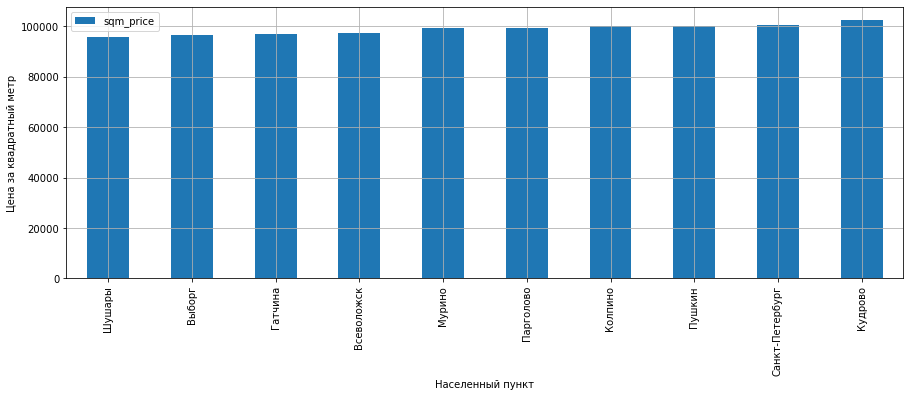

                     sqm_price
locality_name                 
Шушары            95918.485273
Выборг            96593.319367
Гатчина           96898.613909
Всеволожск        97527.393894
Мурино            99411.110593
Парголово         99490.125627
Колпино          100229.338314
Пушкин           100283.246911
Санкт-Петербург  100336.543282
Кудрово          102680.611674


In [54]:
# Список населенных пунктов с наибольшим количеством объявлений
top_localities = data['locality_name'].value_counts(ascending=False).head(10).index
top_localities
(data.query('locality_name in @top_localities')
 .pivot_table(index='locality_name', values=['sqm_price'], aggfunc='mean')
 .sort_values(by='sqm_price', ascending=True)
 .plot(kind='bar', grid='on', xlabel='Населенный пункт', ylabel='Цена за квадратный метр', figsize=(15,5))
)
plt.show()
print(data.query('locality_name in @top_localities')
 .pivot_table(index='locality_name', values=['sqm_price'], aggfunc='mean')
 .sort_values(by='sqm_price', ascending=True))

Наибольшая средняя цена за квадратный метр из 10 населенных пунктов с наибольшим количеством объявлений в Санкт_Петербурге = 115 т.р., а наименьшая в Выборге = 58 т.р.

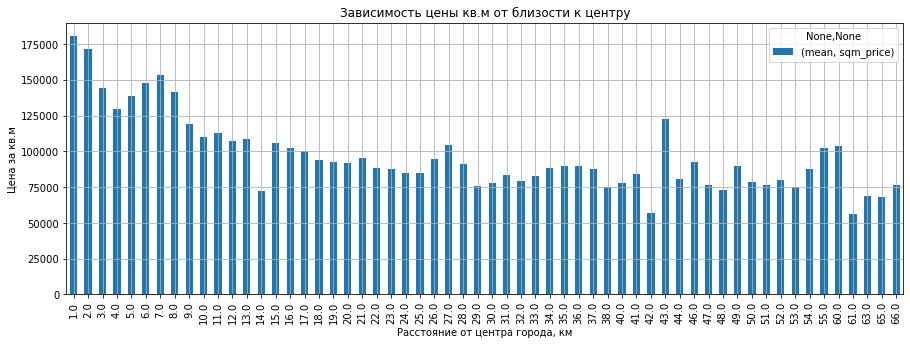

In [55]:
# Расчет средней стоимости каждого км расстояния до центра СПб
(data.query('locality_name == "Санкт-Петербург"')
 .pivot_table(index='city_center_km', values='sqm_price', aggfunc=['mean'])
 .plot(kind='bar', grid=True, figsize=(15,5),
       xlabel='Расстояние от центра города, км', ylabel='Цена за кв.м',
       title='Зависимость цены кв.м от близости к центру')
)
plt.show()

Видна устойчивая обратная линейная зависимость цены кв.м от удаления от центра
Выбиваются некоторые значения от 5 до 8 км, а также 28 км, возможно престижные районы

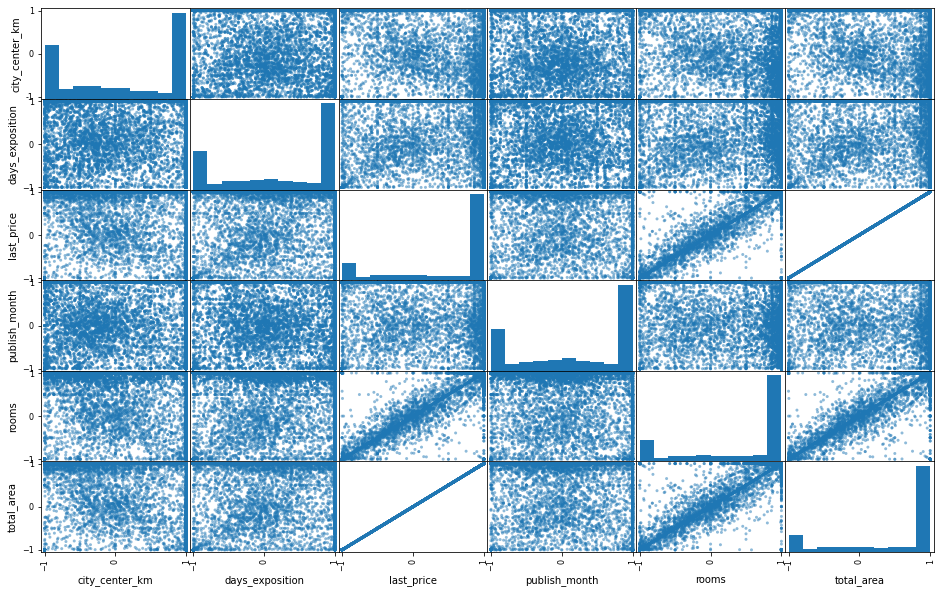

In [56]:
#data.info()
(pd.plotting.scatter_matrix(
    data.pivot_table(index='sqm_price',
                     values=['total_area', 'publish_month', 'days_exposition', 'last_price', 'rooms', 'city_center_km'],
                     aggfunc=('corr')), figsize=(16,10))
)
plt.show()

## Общий вывод

#### Предобработка данных

+ Исходные данные содержали ок. 24 тыс. записей
+ Большая часть записей (5.5 тыс.) не имели заполненных данных геолокации
+ Многие записи содержали ошибки или пропущенные значения
+ Проведено:
    - заполнение пропущенных данных на основании имеющихся,
    - исправление выбивающихся значений на основании гипотез,
    - унификация названий для возможности дальнейшей группировки,
    - удаление безнадежных данных,
    - замена типов данных при необходимости
+ Расчет и добавление дополнительных параметров для группировки по различным признакам и дальнейших расчетов
    
#### Исследовательский анализ

+ Построены распределения по основным параметрам объектов недвижимости
+ Отмечены аномалии и предприняты попытки оценить их влияние и устранить
+ Отмечено снижение активности размещения объявлений в летний период, а также в выходные дни
+ Проанализирована быстрота продажи квартир, выяснено, что скорость продажи зависит от площади (за исключением очень больших), а также

### ИТОГ

+ Подводя итог, можно отметить, что
    - На общую цену объекта влияют в основном площади помещений, а также количество комнат
    - Цена объекта снижается по мере удаления от центра города
    - Цены за кв.м по населенным пунктам различаются, можно провести ранжирование
    - Даты публикации объявлений практически не влияют на цену объекта
    
